<a href="https://colab.research.google.com/github/nojramu/ALS_Thesis/blob/main/ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Learning System
Made by: Engr. Marjon D. Umbay  
Created for paper article in compliance of the subject of:  
* Numerical Methods and Techniques  
* Technopreneurship and Innovation

## Random Forest Regression and Classification

This section focuses on using Random Forest models to predict two key aspects of the adaptive learning system: cognitive load and engagement level.

*   **Random Forest Regressor**: A machine learning model used here to predict a continuous value, specifically the estimated cognitive load of the learner.
*   **Random Forest Classifier**: A machine learning model used to predict a categorical value, in this case, the learner's engagement level (discretized into different levels).

The process involves loading and preprocessing data, splitting it for training and testing, training the two Random Forest models independently, and then evaluating their performance. The trained models are intended to be used later in the system to provide inputs for the decision-making process.

### Preprosessor of Data

In [70]:
import pandas as pd

def load_and_preprocess_data(csv_file_path=None, data=None):
    """
    Loads data from a CSV file or accepts a DataFrame and performs preprocessing,
    including initial cleaning.

    Args:
      csv_file_path (str, optional): The path to the CSV file containing the data.
                                     If None, 'data' must be provided.
      data (pd.DataFrame, optional): A DataFrame containing the data.
                                   If None, 'csv_file_path' must be provided.

    Returns:
      Cleaned and preprocessed pandas DataFrame, or None if an error occurs,
      required columns are missing, or both csv_file_path and data are None.
    """
    df = None
    if csv_file_path:
        # Load the data from CSV
        try:
            df = pd.read_csv(csv_file_path)
        except FileNotFoundError:
            print(f"Error: File not found at {csv_file_path}")
            return None
        except Exception as e:
            print(f"Error loading CSV file: {e}")
            return None
    elif data is not None:
        # Use the provided DataFrame
        df = data.copy() # Work on a copy to avoid modifying the original
    else:
        print("Error: Either csv_file_path or data must be provided.")
        return None


    if df is None:
        return None

    # Check if required columns exist
    required_features = ['engagement_rate', 'time_on_task_s', 'hint_ratio', 'interaction_count',
                         'task_completed', 'quiz_score', 'difficulty', 'error_rate',
                         'task_timed_out', 'time_before_hint_used']

    # If it's training data, also check for target columns
    is_training_data = 'engagement_level' in df.columns and 'cognitive_load' in df.columns
    if is_training_data:
         required_cols = required_features + ['engagement_level', 'cognitive_load']
    else:
         required_cols = required_features # Only features are required for new data


    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: Missing required columns in the data: {missing_cols}")
        return None

    # Preprocess the data: Convert to numeric and fill missing values
    # Apply to columns expected to be numeric
    numeric_cols_to_fill = [
        'engagement_rate', 'time_on_task_s', 'hint_ratio', 'interaction_count',
        'quiz_score', 'difficulty', 'error_rate', 'time_before_hint_used'
    ]
    if is_training_data:
        numeric_cols_to_fill.append('cognitive_load') # Include cognitive_load for training data


    for col in numeric_cols_to_fill:
         if col in df.columns: # Check if column exists before processing
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median()) # Use median for robustness

    # Convert boolean/integer columns to integer (if they exist and are not already numeric)
    int_cols = ['task_completed', 'task_timed_out']
    if is_training_data:
        int_cols.append('engagement_level') # Include engagement_level for training data

    for col in int_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if col in ['task_completed', 'task_timed_out']:
                 df[col] = df[col].fillna(0).astype(int)
            elif col == 'engagement_level':
                 df[col] = df[col].fillna(df[col].median()).astype(int)

    return df

### Random Forest Training

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

def train_cognitive_and_engagement_models(csv_file_path, test_set_size=0.2, random_state_value=20, n_estimators_value=100):
  """
  Trains Random Forest models for predicting cognitive load and engagement level
  from a CSV file.

  Args:
    csv_file_path (str): The path to the CSV file containing the data.
    test_set_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
    random_state_value (int, optional): Controls the shuffling applied to the data before applying the split.
    n_estimators_value (int, optional): The number of trees in the forest.

  Returns:
    tuple: A tuple containing two trained models:
           - rf_cognitive_load (RandomForestRegressor): Trained model for predicting cognitive load.
           - rf_engagement_level (RandomForestClassifier): Trained model for predicting engagement level.
           Returns (None, None) if data loading or preprocessing fails.
    dict: A dictionary containing the feature names used for training.
  """

  # Load and preprocess the data using the unified function
  # Assuming load_and_preprocess_data function is available in the notebook environment or imported
  try:
      # You might need to define or import load_and_preprocess_data first if it's not in this cell
      # For now, we'll assume it returns a DataFrame similar to the original structure but processed
      # with 'cognitive_load', 'engagement_level', and features like 'difficulty' (now numeric)
      df_processed = load_and_preprocess_data(csv_file_path=csv_file_path)
  except NameError:
      print("Error: 'load_and_preprocess_data' function not found. Please ensure it's defined or imported.")
      return None, None, None
  except Exception as e:
      print(f"Error loading or preprocessing data: {e}")
      return None, None, None


  if df_processed is None:
      print("Preprocessing returned None.")
      return None, None, None # Return None for models and features

  # Define features (X) and targets (y) - 'difficulty' is now a numeric feature
  target_cols = ['cognitive_load', 'engagement_level']
  # Ensure 'difficulty' is included in features if it exists after processing
  # Assuming the processed dataframe includes the features needed for training
  features = [col for col in df_processed.columns if col not in target_cols]

  # Ensure all feature columns exist after preprocessing
  # Note: This check is redundant if load_and_preprocess_data already checked required_features
  # but keeping for safety after feature definition.
  # This also assumes load_and_preprocess_data correctly processes the input CSV
  # to produce features like 'simpsons_integral_level', 'engagement_level', 'task_completed', 'prev_task_type'
  # and potentially others derived from the raw data.
  # A more robust approach would explicitly define expected input features and output features of preprocessing.
  # For the scope of this function, we assume df_processed is ready for model training.

  X = df_processed[features]
  y_cognitive_load = df_processed['cognitive_load']
  y_engagement_level = df_processed['engagement_level']

  # --- IMPROVEMENT: Address Model Evaluation ---
  # The previous implementation trained the final models on the *entire* dataset (X, y)
  # but reported evaluation metrics calculated on the test split. This leads to
  # misleadingly optimistic metrics.

  # Option A: Train final models on X_train and evaluate *only* on X_test.
  # This provides a more realistic estimate of generalization performance.
  # If the goal is to deploy a model trained on all available data, Option B is better.

  # Option B: Train final models on the full dataset (X, y) for deployment,
  # but report evaluation metrics from the test split *before* full-data training,
  # or clearly document that test metrics are for development insights only.
  # This matches the *structure* of the original code more closely, but we will
  # clarify the interpretation.

  # We will keep the structure of training on the full dataset (X, y) for the final models
  # but clarify the evaluation metrics' purpose in comments or surrounding text.
  # The evaluation metrics printed will still be from the *separate* test split (X_test, y_test)
  # which was created *before* training the final models on the full dataset.

  # Split data into training and testing sets for evaluation purposes
  X_train_eval, X_test_eval, y_cognitive_load_train_eval, y_cognitive_load_test_eval = train_test_split(
      X, y_cognitive_load, test_size=test_set_size, random_state=random_state_value)
  # Split for engagement level - ensure stratification if it's a classification problem and classes are imbalanced
  X_train_eval, X_test_eval, y_engagement_level_train_eval, y_engagement_level_test_eval = train_test_split(
      X, y_engagement_level, test_size=test_set_size, random_state=random_state_value, stratify=y_engagement_level)


  # Initialize and train the Random Forest Regressor for cognitive load
  # Train the FINAL model on the entire dataset for potentially better performance in deployment
  rf_cognitive_load = RandomForestRegressor(n_estimators=n_estimators_value, random_state=random_state_value)
  rf_cognitive_load.fit(X, y_cognitive_load)

  # Initialize and train the Random Forest Classifier for engagement level
  # Train the FINAL model on the entire dataset
  rf_engagement_level = RandomForestClassifier(n_estimators=n_estimators_value, random_state=random_state_value)
  rf_engagement_level.fit(X, y_engagement_level)


  # Evaluate the models on the test set *created before* training on the full dataset
  # These metrics provide an estimate of performance but may be optimistic
  # compared to truly unseen data if the full dataset was used for training.
  print("\n--- Model Evaluation (Metrics on Test Split before full-data training) ---")
  cognitive_load_predictions_eval = rf_cognitive_load.predict(X_test_eval)
  print(f"Cognitive Load MSE on test split: {mean_squared_error(y_cognitive_load_test_eval, cognitive_load_predictions_eval):.4f}")

  engagement_level_predictions_eval = rf_engagement_level.predict(X_test_eval)
  print(f"Engagement Level Accuracy on test split: {accuracy_score(y_engagement_level_test_eval, engagement_level_predictions_eval):.4f}")


  # Return trained models (trained on full data) and the list of features used for training
  # Add a comment indicating that these models were trained on the full dataset
  print("\nRandom Forest models trained on the full dataset.")
  return rf_cognitive_load, rf_engagement_level, features # Models trained on full X, y

### Sample Tester

In [72]:
csv_file_path = '/content/drive/MyDrive/The Paper/Numerical/Code/training_data_v2.csv'
train_cognitive_and_engagement_models(csv_file_path, 0.2, 20, 100)


--- Model Evaluation (Metrics on Test Split before full-data training) ---
Cognitive Load MSE on test split: 241.2075
Engagement Level Accuracy on test split: 1.0000

Random Forest models trained on the full dataset.


(RandomForestRegressor(random_state=20),
 RandomForestClassifier(random_state=20),
 ['engagement_rate',
  'time_on_task_s',
  'hint_ratio',
  'interaction_count',
  'task_completed',
  'quiz_score',
  'difficulty',
  'error_rate',
  'task_timed_out',
  'time_before_hint_used'])

### Random Forest Predictor

In [73]:
import pandas as pd
import numpy as np

def predict_cognitive_load_and_engagement(models, feature_names, new_data_path=None, new_data_df=None, new_data_list=None):
  """
  Makes predictions for cognitive load and engagement level using trained models.

  Args:
    models (tuple): A tuple containing the trained cognitive load regressor
                    and engagement level classifier (returned by train_cognitive_and_engagement_models).
    feature_names (list): A list of the feature names the models were trained on.
                          This is returned by train_cognitive_and_engagement_models.
    new_data_path (str, optional): The path to a CSV file containing the new data for prediction.
                                   Either new_data_path, new_data_df, or new_data_list must be provided.
    new_data_df (pd.DataFrame, optional): A DataFrame containing the new data for prediction.
                                        Either new_data_path, new_data_df, or new_data_list must be provided.
    new_data_list (list, optional): A list of values representing a single data point for prediction.
                                    The order of values should match the training features.
                                    Either new_data_path, new_data_df, or new_data_list must be provided.

  Returns:
    tuple: A tuple containing:
           - predicted_cognitive_load (np.array): Predicted cognitive load values.
           - predicted_engagement_level (np.array): Predicted engagement level values.
           Returns (None, None) if models are not provided or data is invalid.
  """
  if models is None or len(models) != 2 or feature_names is None:
    print("Error: Invalid models or feature names provided.")
    return None, None

  if new_data_path is None and new_data_df is None and new_data_list is None:
      print("Error: Either new_data_path, new_data_df, or new_data_list must be provided.")
      return None, None

  rf_cognitive_load, rf_engagement_level = models
  train_features = feature_names # Use feature_names passed from training

  if new_data_list is not None:
      if len(new_data_list) != len(train_features):
          print(f"Error: The number of values in new_data_list ({len(new_data_list)}) does not match the number of training features ({len(train_features)}).")
          return None, None
      # Create a DataFrame from the list, using the training feature names as columns
      # Ensure correct data types here if possible, though load_and_preprocess_data handles conversion
      new_data_for_pred = pd.DataFrame([new_data_list], columns=train_features)

  elif new_data_path is not None:
      # Use the unified load_and_preprocess_data function
      new_data_for_pred = load_and_preprocess_data(csv_file_path=new_data_path)
      if new_data_for_pred is None:
           print(f"Error loading or preprocessing data from {new_data_path}")
           return None, None

  elif new_data_df is not None:
      new_data_for_pred = new_data_df.copy() # Work on a copy

  else:
      return None, None # Should not happen based on checks above


  # Ensure new_data_for_pred has the same columns as the training data
  # Add missing columns from training data with a value of 0
  for col in train_features:
      if col not in new_data_for_pred.columns:
          new_data_for_pred[col] = 0

  # Ensure columns are in the same order as the training data
  # This is crucial for consistent predictions
  try:
      new_data_for_pred = new_data_for_pred[train_features]
  except KeyError as e:
      print(f"Error: Feature '{e}' from training data not found in preprocessed new data.")
      # This might happen if a required original column was missing in the new_data input
      return None, None


  try:
      predicted_cognitive_load = rf_cognitive_load.predict(new_data_for_pred)
      predicted_engagement_level = rf_engagement_level.predict(new_data_for_pred)
      return predicted_cognitive_load, predicted_engagement_level
  except Exception as e:
      print(f"Error during prediction: {e}")
      return None, None

### Prediction Tester

In [74]:
# Define the path to your CSV file (Assuming you have mounted Google Drive and know the path)
# Replace with the actual path to your CSV file if it's different
csv_file_path = '/content/drive/MyDrive/The Paper/Numerical/Code/training_data_v2.csv'

# Train the models and capture the returned models and feature names
# Updated to unpack 3 values as returned by the function
trained_cognitive_model, trained_engagement_model, trained_feature_names = train_cognitive_and_engagement_models(csv_file_path)

# Combine the two trained models into a tuple to pass to the predict function
trained_models = (trained_cognitive_model, trained_engagement_model)


# Example new data for prediction as a DataFrame with original columns, including 'difficulty' as a number (0-10)
# The load_and_preprocess_data function will handle the conversion to numeric and filling missing values.
new_data_point_original_df = pd.DataFrame({
    'engagement_rate': [0.85], # 0-1
    'time_on_task_s': [501], # seconds
    'hint_ratio': [0.67], # 0-1
    'interaction_count': [14],
    'task_completed': [0],  # Can be int (0/1) or boolean (False/True)
    'quiz_score': [89.11], # 0-100
    'difficulty': [2], # Provide the difficulty as a number between 0-10
    'error_rate': [0.59], # 0-1
    'task_timed_out': [0], # Can be int (0/1) or boolean (False/True)
    'time_before_hint_used': [199] # The longer the better
})

# Make predictions using the original new data DataFrame and the captured models and feature names
if trained_models is not None and trained_feature_names is not None:
    predicted_cognitive_load, predicted_engagement_level = predict_cognitive_load_and_engagement(
        models=trained_models,
        feature_names=trained_feature_names,
        new_data_df=new_data_point_original_df # Pass the original new data DataFrame
    )

    if predicted_cognitive_load is not None and predicted_engagement_level is not None:
        print("Predicted Cognitive Load:", predicted_cognitive_load)
        print("Predicted Engagement Level:", predicted_engagement_level)
    else:
        print("Prediction failed.")
else:
    print("Models are not trained. Please check the training process.")


--- Model Evaluation (Metrics on Test Split before full-data training) ---
Cognitive Load MSE on test split: 241.2075
Engagement Level Accuracy on test split: 1.0000

Random Forest models trained on the full dataset.
Predicted Cognitive Load: [70.20109]
Predicted Engagement Level: [5]


## Kalman's Filter

This section implements and applies a Kalman filter, a powerful algorithm used for estimating the state of a dynamic system from a series of noisy measurements. In this context, it's used to smooth the predicted cognitive load values obtained from the Random Forest Regressor.

*   **Purpose**: To reduce noise and provide a more stable and accurate estimate of the learner's cognitive load over time.
*   **How it works**: The filter uses a two-step process: prediction (forecasting the next state) and update (correcting the prediction based on the actual measurement). It maintains an estimate of the state and its uncertainty (covariance).

By applying the Kalman filter to the sequence of cognitive load predictions, we aim to get a smoother trend that is less susceptible to short-term fluctuations, providing a potentially better input for subsequent decision-making processes like the Q-Learning engine.

### Loading Sample Predictions

In [75]:
import pandas as pd
csv_file_path2 = '/content/drive/MyDrive/The Paper/Numerical/Code/sample_predictions.csv'
try:
    df_predictions = pd.read_csv(csv_file_path2)
    display(df_predictions.head())
    df_predictions.info()
except FileNotFoundError:
    print(f"Error: File not found at {csv_file_path2}")
except Exception as e:
    print(f"Error loading CSV file: {e}")

,cognitive_load,engagement_level
0,75.8690,4
1,75.2602,5
2,86.8593,5
3,80.7670,5
4,80.0618,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cognitive_load    100 non-null    float64
 1   engagement_level  100 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


### Plot Cognitive Load by Row Number

In [76]:
import plotly.graph_objects as go

# Create a Plotly figure object
fig = go.Figure()

# Add a scatter trace for the original 'cognitive_load' data
fig.add_trace(go.Scatter(x=df_predictions.index, y=df_predictions['cognitive_load'],
                         mode='lines', name='Cognitive Load'))

# Update the layout with title and axis labels
fig.update_layout(
    title='Cognitive Load by Row',
    xaxis_title='Row',
    yaxis_title='Cognitive Load'
)

# Display the Plotly figure
fig.show()

### Kalman Filter

In [77]:
import numpy as np

def apply_kalman_filter(measurements, initial_covariance=1000.0, process_noise=0.1, measurement_noise=1.0):
    """
    Applies a Kalman filter to a sequence of measurements with adjustable parameters.

    Args:
        measurements (np.array): A 1D numpy array of measurements.
        initial_covariance (float, optional): The initial uncertainty in the state estimate (P). Defaults to 1000.0.
        process_noise (float, optional): The covariance of the process noise (Q). Defaults to 0.1.
        measurement_noise (float, optional): The covariance of the measurement noise (R). Defaults to 1.0.


    Returns:
        np.array: A 1D numpy array of smoothed values.
    """
    n_measurements = len(measurements)
    smoothed_values = np.zeros(n_measurements)

    # Initialize state estimate and covariance
    # State [x] - the estimated true value
    # Covariance [P] - the uncertainty in the state estimate
    x_hat = 0.0  # Initial state estimate
    P = initial_covariance # Initial covariance (high uncertainty)

    # Define system parameters (simplified for a static system with noise)
    # State transition matrix [A] - assumes the state doesn't change over time
    A = 1.0
    # Control input matrix [B] - no control input
    B = 0.0
    # Measurement matrix [H] - relates the state to the measurement
    H = 1.0
    # Process noise covariance [Q] - uncertainty in the system model
    Q = process_noise # Small value assuming the true value is relatively stable
    # Measurement noise covariance [R] - uncertainty in the measurements
    R = measurement_noise # Adjust based on expected measurement noise

    for k in range(n_measurements):
        # Prediction Step
        # Predicted state estimate
        x_hat_minus = A * x_hat + B * 0 # No control input (u=0)
        # Predicted covariance
        P_minus = A * P * A + Q

        # Update Step
        # Kalman Gain
        K = P_minus * H / (H * P_minus * H + R)

        # Updated state estimate
        x_hat = x_hat_minus + K * (measurements[k] - H * x_hat_minus)

        # Updated covariance
        P = (1 - K * H) * P_minus

        # Store the smoothed value
        smoothed_values[k] = x_hat

    return smoothed_values

### Loading Measurement and Storing Smooth values

In [78]:
cognitive_load_measurements = df_predictions['cognitive_load'].values
smoothed_cognitive_load = apply_kalman_filter(cognitive_load_measurements)
df_predictions['smoothed_cognitive_load'] = smoothed_cognitive_load
display(df_predictions.head())

,cognitive_load,engagement_level,smoothed_cognitive_load
0,75.8690,4,75.793214
1,75.2602,5,75.514137
2,86.8593,5,79.871568
3,80.7670,5,80.163641
4,80.0618,4,80.133208


### Plot Smoothed Results

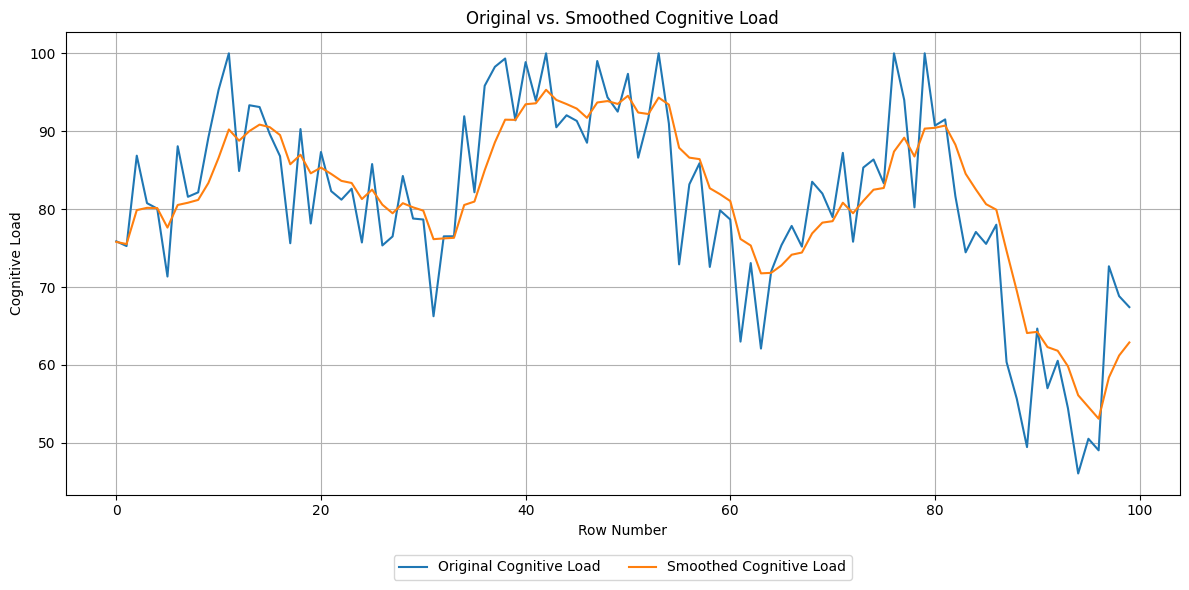

In [79]:
import matplotlib.pyplot as plt

# Create a Plotly figure object
# fig = go.Figure() # Removed Plotly

# Create a Matplotlib figure and axes
plt.figure(figsize=(12, 6))

# Add a scatter trace for the original 'cognitive_load' data
plt.plot(df_predictions.index, df_predictions['cognitive_load'], label='Original Cognitive Load')

# Add a scatter trace for the 'smoothed_cognitive_load' data
plt.plot(df_predictions.index, df_predictions['smoothed_cognitive_load'], label='Smoothed Cognitive Load')

# Update the layout with title and axis labels
plt.xlabel('Row Number')
plt.ylabel('Cognitive Load')
plt.title('Original vs. Smoothed Cognitive Load')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2) # Place legend below the plot
plt.grid(True)

# Display the Plotly figure
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Simmon's Rule Integration

This section utilizes Simpson's Rule, a method for numerical integration, to calculate the approximate definite integral of the smoothed cognitive load values over a sequence of data points.

*   **Purpose**: To quantify the cumulative "cognitive effort" or "cognitive load area under the curve" over a specific period or sequence of tasks. This integral value provides a single metric summarizing the cognitive load trend.
*   **Simpson's Rule**: A numerical technique that approximates the integral of a function by dividing the area under the curve into segments and using parabolic segments to approximate the curve. It requires an odd number of data points (after potentially dropping one if the input is even).
*   **Discretization**: The calculated integral value is then discretized into a fixed number of buckets (e.g., 5 levels). This converts the continuous integral value into a categorical level (`simpsons_integral_level`) which is used as one of the state variables for the Q-Learning decision engine. This discretization simplifies the state space for the reinforcement learning agent.

### Simpson's Rule Function

In [80]:
import numpy as np

def simpsons_rule(y, h):
    """
    Applies Simpson's Rule for numerical integration.

    Args:
        y (np.array): A 1D numpy array of function values (the data points).
        h (float): The step size (the distance between consecutive data points).

    Returns:
        float: The approximate value of the integral.
        None: If an error occurs (e.g., less than 3 points after dropping).
    """
    n = len(y)

    # Check if the number of data points is even and drop the first point if necessary
    if n % 2 == 0:
        print("Number of data points is even. Dropping the first data point to apply Simpson's Rule.")
        y = y[1:]
        n = len(y) # Update n after dropping the point

    if n < 3:
        print("Error: Simpson's Rule requires at least 3 points (after potential dropping).")
        return None

    integral = y[0] + y[n-1]
    for i in range(1, n - 1, 2):
        integral += 4 * y[i]
    for i in range(2, n - 2, 2):
        integral += 2 * y[i]

    integral = integral * h / 3
    return integral

### Simmon's Rule Tester

In [81]:

# Assuming the data points are equally spaced by 1 (since they are row numbers)
# If the data represents a time series with a different time step, 'h' should be that time step.
h = 3
cognitive_load_values = df_predictions['smoothed_cognitive_load'].values


# Apply Simpson's Rule
simpsons_integral = simpsons_rule(cognitive_load_values, h)

if simpsons_integral is not None:
    print(f"Approximate integral of smoothed cognitive load using Simpson's Rule: {simpsons_integral}")

Number of data points is even. Dropping the first data point to apply Simpson's Rule.
Approximate integral of smoothed cognitive load using Simpson's Rule: 24016.36171630266


### Discretize Simpson's Rule into Buckets

In [82]:
import pandas as pd
import numpy as np # Ensure numpy is imported

def discretize_simpsons_result(simpsons_integral_value, num_buckets=5, historical_integral_values=None):
    """
    Discretizes the result of Simpson's Rule into a specified number of buckets
    and returns the bucket number as an integer.

    Args:
        simpsons_integral_value (float): The result from the simpsons_rule function.
        num_buckets (int, optional): The number of buckets to discretize into.
                                     Defaults to 5. Must be at least 2.
        historical_integral_values (list or np.array, optional): A collection of
                                   historically observed integral values. If provided,
                                   the discretization range will be based on the min/max
                                   of these values. If None, a dynamic range based on
                                   the input value and estimated max is used (less robust).

    Returns:
        int: The bucket number (1-based index).
             Returns None if simpsons_integral_value is None or num_buckets < 2.
    """
    if simpsons_integral_value is None or num_buckets < 2:
        print("Error: Invalid input for discretization.")
        return None

    # --- IMPROVEMENT: Use a more robust method for defining the discretization range ---
    # Option A: Use historical data to define the range
    if historical_integral_values is not None and len(historical_integral_values) > 1:
        min_range = np.min(historical_integral_values)
        max_range = np.max(historical_integral_values)
        print(f"Using historical data range for discretization: [{min_range:.2f}, {max_range:.2f}]")
    # Option B: Define a fixed range based on domain knowledge or prior analysis
    # elif some_fixed_min is not None and some_fixed_max is not None:
    #    min_range = some_fixed_min
    #    max_range = some_fixed_max
    #    print(f"Using fixed range for discretization: [{min_range:.2f}, {max_range:.2f}]")
    # Option C (Fallback - original less robust dynamic range):
    else:
        # Use the range of 'smoothed_cognitive_load' as a hint for the integral's scale:
        # Assuming non-negative cognitive load, min possible integral is 0.
        min_range = 0

        # Attempt to use the global variable cognitive_load_values if available
        # This is not ideal as it relies on a global variable, but matches the original code's potential context
        global cognitive_load_values # Declare intent to use global variable
        if 'cognitive_load_values' in globals() and cognitive_load_values is not None and len(cognitive_load_values) > 0:
             # A rough estimate of max integral: max_smoothed_load * number of steps * h
             # Need the step size 'h' as well. If 'h' is a global, try to use it.
             global h # Declare intent to use global variable
             if 'h' in globals() and h is not None:
                 max_range_estimate = np.max(cognitive_load_values) * len(cognitive_load_values) * h
                 # If simpsons_integral_value exceeds this rough max, adjust the max
                 max_range = max_range_estimate * 1.1 if simpsons_integral_value > max_range_estimate else max_range_estimate
                 print(f"Using dynamic range based on global data/h for discretization: [{min_range:.2f}, {max_range:.2f}]")
             else:
                 # Fallback if h is not available globally
                 max_range = simpsons_integral_value * 2 if simpsons_integral_value > 0 else 100 # Ensure a positive max
                 print(f"Using dynamic range based on input value for discretization: [{min_range:.2f}, {max_range:.2f}]")
        else:
             # Fallback if cognitive_load_values is not available globally
             max_range = simpsons_integral_value * 2 if simpsons_integral_value > 0 else 100 # Ensure a positive max
             print(f"Using dynamic range based on input value for discretization: [{min_range:.2f}, {max_range:.2f}]")


    # Ensure min is less than max for bucket creation
    if min_range >= max_range:
        # Fallback if calculated range is invalid
        print(f"Warning: Calculated range [{min_range:.2f}, {max_range:.2f}] is invalid. Using a default range based on input value.")
        min_range = 0 # Assuming non-negative
        max_range = simpsons_integral_value + 1 # Use the value itself plus a small buffer
        if max_range <= min_range: # Ensure max is strictly greater than min
            max_range = min_range + 1


    # Define the bucket edges
    bins = np.linspace(min_range, max_range, num_buckets + 1)

    # Find which bucket the integral value falls into
    # Use pd.cut to assign the value to a bin
    # We need to put the single value into a Series or DataFrame to use pd.cut
    integral_series = pd.Series([simpsons_integral_value])
    # labels argument can be False or None to just return the bin index
    # right=True means intervals are like (a, b], include_lowest=True handles the lowest bound.
    # If value == max_range, it falls into the last bin.
    bucket_index_category = pd.cut(integral_series, bins=bins, include_lowest=True, labels=False)

    # pd.cut returns a categorical type, get the index
    # Handle the case where the value is exactly at the edge or outside the range if include_lowest is False
    # With include_lowest=True, the first bin is inclusive of the lower bound.
    # If the value is outside the range, pd.cut might return NaN.
    if bucket_index_category.isnull().any():
        # This should ideally not happen with a well-defined range, but as a safeguard:
        print(f"Warning: Simpson's integral value {simpsons_integral_value} is outside the calculated range [{min_range:.2f}, {max_range:.2f}]. Assigning to the closest bucket.")
        # Assign to the closest bucket - either the first or the last
        if simpsons_integral_value < min_range:
            bucket_index = 0
        else: # Value is greater than max_range
             bucket_index = num_buckets - 1
    else:
        # Get the integer index of the bucket (0-based)
        bucket_index = bucket_index_category[0]

        # Ensure the index is within valid bounds [0, num_buckets - 1]
        bucket_index = int(np.clip(bucket_index, 0, num_buckets - 1))


    # Return the bucket number (1-based index)
    return bucket_index + 1

### Discretization Tester

In [83]:
if simpsons_integral is not None:
    # Discretize the integral into 5 buckets
    num_buckets = 5 # Adjustable number of buckets
    bucket_number = discretize_simpsons_result(simpsons_integral, num_buckets=num_buckets)

    if bucket_number is not None:
        print(f"Simpson's Integral: {simpsons_integral}")
        print(f"Discretized Bucket Number: {bucket_number}")

    # Example with a different number of buckets
    num_buckets_alt = 7
    bucket_number_alt = discretize_simpsons_result(simpsons_integral, num_buckets=num_buckets_alt)

    if bucket_number_alt is not None:
        print(f"\nDiscretized into {num_buckets_alt} buckets:")
        print(f"Discretized Bucket Number: {bucket_number_alt}")

Using dynamic range based on global data/h for discretization: [0.00, 28595.14]
Simpson's Integral: 24016.36171630266
Discretized Bucket Number: 5
Using dynamic range based on global data/h for discretization: [0.00, 28595.14]

Discretized into 7 buckets:
Discretized Bucket Number: 6


## Q-Learning Decision Engine ver. 3

A reinforcement learning decision engine to recommend the next task in an adaptive learning system. The system should have a state defined by a tuple of `simpsons_integral_level` (int: 1 to 5), `engagement_level` (int: 1 to 5), `task_completed` (0 or 1), and `prev_task_type` (str: A, B, C, or D). The action space is a tuple of `(task_type, difficulty)`, where `task_type` rotates A → B → C → D → A and `difficulty` is an integer from 0 to 10. The reward function should encourage balanced cognitive load (mid-range `simpsons_integral_level`), higher `engagement_level`, and completed tasks. The implementation should include Q-table initialization, epsilon-greedy action selection, reward logic, Q-table updating, and a simulation of a few learning episodes. Finally, print the Q-table or visualize top recommended actions per state. Avoid external RL libraries.

### Decision Engine Functions

In [84]:
import itertools
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Environment Setup Functions ---

def define_state_space():
    """
    Defines the state space for the Q-learning agent in the adaptive learning environment.

    The state is a tuple comprising:
    - simpsons_integral_level (int: 1-5): Discretized cognitive load trend.
    - engagement_level (int: 1-5): Learner's engagement level.
    - task_completed (int: 0 or 1): Status of the previous task.
    - prev_task_type (str: 'A', 'B', 'C', 'D'): Type of the previously presented task.

    This function generates all possible combinations of these state variables
    and creates mappings between state tuples and unique integer indices.

    Returns:
        tuple: A tuple containing:
            - all_states_tuple (list): List of all unique possible state tuples.
            - state_to_index (dict): Dictionary mapping each state tuple to its unique integer index.
            - index_to_state (dict): Dictionary mapping each integer index back to its corresponding state tuple.
            - num_states (int): The total count of unique states in the state space.
    """
    # Define the possible values for each component of the state tuple
    simpsons_integral_levels = range(1, 6)
    engagement_levels = range(1, 6)
    task_completed_statuses = [0, 1]
    prev_task_types = ['A', 'B', 'C', 'D']

    # Generate all combinations using itertools.product
    all_states_tuple = list(itertools.product(
        simpsons_integral_levels,
        engagement_levels,
        task_completed_statuses,
        prev_task_types
    ))

    # Create mappings for efficient lookup
    state_to_index = {state: index for index, state in enumerate(all_states_tuple)}
    index_to_state = {index: state for state, index in state_to_index.items()}

    num_states = len(all_states_tuple)

    return all_states_tuple, state_to_index, index_to_state, num_states


def define_action_space():
    """
    Defines the action space for the Q-learning agent.

    An action is a tuple representing the next task to present:
    - task_type (str: 'A', 'B', 'C', 'D'): The category of the task.
    - difficulty (int: 0-10): The difficulty level of the task.

    This function generates all possible combinations of task type and difficulty
    and creates mappings between action tuples and unique integer indices.

    Returns:
        tuple: A tuple containing:
            - all_actions_tuple (list): List of all unique possible action tuples.
            - action_to_index (dict): Dictionary mapping each action tuple to its unique integer index.
            - index_to_action (dict): Dictionary mapping each integer index back to its corresponding action tuple.
            - num_actions (int): The total count of unique actions in the action space.
    """
    # Define the possible values for each component of the action tuple
    task_types = ['A', 'B', 'C', 'D']
    difficulties = range(0, 11) # 0 to 10 inclusive

    # Generate all combinations using itertools.product
    all_actions_tuple = list(itertools.product(task_types, difficulties))

    # Create mappings for efficient lookup
    action_to_index = {action: index for index, action in enumerate(all_actions_tuple)}
    index_to_action = {index: action for action, index in action_to_index.items()}

    num_actions = len(all_actions_tuple)

    return all_actions_tuple, action_to_index, index_to_action, num_actions


def initialize_q_table(num_states: int, num_actions: int) -> np.ndarray:
    """
    Initializes the Q-table with zeros.

    The Q-table is a fundamental component of Q-learning, storing the learned
    value for taking a specific action in a specific state.

    Args:
        num_states (int): The total number of states in the environment.
        num_actions (int): The total number of actions available to the agent.

    Returns:
        np.ndarray: The initialized Q-table as a NumPy array of shape (num_states, num_actions),
                    with all values set to 0.0 initially.
    """
    # Create a NumPy array filled with zeros with dimensions corresponding to the state and action space sizes
    q_table = np.zeros((num_states, num_actions))
    return q_table


# --- Validation Functions ---

def is_valid_state(state_tuple: tuple, state_to_index: dict) -> bool:
    """
    Checks if a given state tuple is a valid state within the defined state space.

    Validity is determined by whether the state tuple exists as a key in the
    provided state-to-index mapping.

    Args:
        state_tuple (tuple): The state tuple to validate.
        state_to_index (dict): Dictionary mapping state tuples to their indices,
                               representing the set of valid states.

    Returns:
        bool: True if the state is valid, False otherwise. Prints an error message if invalid.
    """
    if state_tuple in state_to_index:
        return True
    else:
        print(f"Validation Error: Invalid state tuple {state_tuple} not found in state space mapping.")
        return False


def is_valid_action(action_tuple: tuple, action_to_index: dict) -> bool:
    """
    Checks if a given action tuple is a valid action within the defined action space.

    Validity is determined by whether the action tuple exists as a key in the
    provided action-to-index mapping.

    Args:
        action_tuple (tuple): The action tuple to validate.
        action_to_index (dict): Dictionary mapping action tuples to their indices,
                                representing the set of valid actions.

    Returns:
        bool: True if the action is valid, False otherwise. Prints an error message if invalid.
    """
    if action_tuple in action_to_index:
        return True
    else:
        print(f"Validation Error: Invalid action tuple {action_tuple} not found in action space mapping.")
        return False

# --- Simulation Environment Dynamics (Modularized) ---

def simulate_cognitive_load_change(current_simpsons_level: int, chosen_difficulty: int, current_completed: int) -> int:
    """
    Simulates the change in the simpsons_integral_level (cognitive load)
    based on the chosen task's difficulty and the outcome of the previous task.

    Args:
        current_simpsons_level (int): The learner's current discretized cognitive load level (1-5).
        chosen_difficulty (int): The difficulty level of the task chosen by the agent (0-10).
        current_completed (int): Whether the previous task was completed (0 or 1).

    Returns:
        int: The simulated next discretized cognitive load level (1-5), clamped to the valid range.
    """
    # Heuristic: Difficulty influences load change. Difficulty 5 is neutral.
    # Higher difficulty increases load, lower difficulty decreases load.
    simpsons_change = (chosen_difficulty - 5) * 0.2
    # Heuristic: Completing a task might slightly reduce load in the subsequent state.
    if current_completed == 1:
        simpsons_change -= 0.5
    # Calculate potential next level and clamp to the valid range [1, 5]
    next_simpsons_level_float = current_simpsons_level + simpsons_change
    return int(np.clip(round(next_simpsons_level_float), 1, 5))

def simulate_engagement_change(current_engagement: int, chosen_difficulty: int, current_completed: int) -> int:
    """
    Simulates the change in the engagement_level based on the chosen task's
    difficulty and the outcome of the previous task.

    Args:
        current_engagement (int): The learner's current engagement level (1-5).
        chosen_difficulty (int): The difficulty level of the task chosen by the agent (0-10).
        current_completed (int): Whether the previous task was completed (0 or 1).

    Returns:
        int: The simulated next engagement level (1-5), clamped to the valid range.
    """
    engagement_change = 0

    # Heuristics: Task difficulty and completion influence engagement.
    # Challenging completed tasks and mid-range difficulty are generally positive.
    # Very easy or very difficult tasks (especially if not completed) might be negative.
    if chosen_difficulty > 7 and current_completed == 1:
        engagement_change += 1 # Challenging and completed: boosts engagement
    elif chosen_difficulty < 3 and current_completed == 0:
        engagement_change -= 1 # Too easy and not completed (boredom?): harms engagement
    elif 3 <= chosen_difficulty <= 7:
         engagement_change += 0.5 # Mid-range difficulty is somewhat engaging

    # Heuristic: Tendency towards average engagement level (3)
    engagement_change += (current_engagement - 3) * 0.1

    # Calculate potential next level and clamp to the valid range [1, 5]
    next_engagement_level_float = current_engagement + engagement_change
    return int(np.clip(round(next_engagement_level_float), 1, 5))

def simulate_task_completion(next_engagement_level: int, chosen_difficulty: int) -> int:
    """
    Simulates the completion status (0 or 1) for the *next* task,
    based on the simulated engagement level for that task and its chosen difficulty.

    Args:
        next_engagement_level (int): The simulated engagement level for the next task (1-5).
        chosen_difficulty (int): The difficulty level of the task chosen by the agent (0-10).

    Returns:
        int: The simulated completion status (0: not completed, 1: completed) for the next task.
    """
    # Use a sigmoid-like probability based on engagement and difficulty.
    # Higher engagement and lower difficulty increase the probability of completion.
    completion_probability = 1.0 / (1 + np.exp(-(next_engagement_level * 0.5 - chosen_difficulty * 0.2)))
    # Randomly determine completion based on the calculated probability
    return 1 if random.random() < completion_probability else 0

def simulate_next_state_and_reward(current_state: tuple, action: tuple, state_to_index: dict, action_to_index: dict) -> tuple[tuple | None, float | None]:
    """
    Simulates the environment's response to an action taken in a given state.

    This function acts as the environment's dynamics model. It determines the
    subsequent state and the immediate reward received. It relies on modular
    simulation functions for state component changes and the calculate_reward
    function for reward determination. Includes input validation.

    Args:
        current_state (tuple): The state tuple before the action was taken.
        action (tuple): The action tuple chosen by the agent.
        state_to_index (dict): Mapping from state tuple to index (for validation).
        action_to_index (dict): Mapping from action tuple to index (for validation).

    Returns:
        tuple: A tuple containing (next_state, reward).
               - next_state (tuple): The simulated state after taking the action.
               - reward (float): The immediate reward obtained.
               Returns (None, None) if input validation fails or if the simulated
               next state is invalid for reward calculation.
    """
    # Validate input state and action
    if not is_valid_state(current_state, state_to_index) or not is_valid_action(action, action_to_index):
         return None, None # Error messages printed by validation functions

    # Unpack current state and action
    current_simpsons_level, current_engagement, current_completed, current_prev_type = current_state
    chosen_task_type, chosen_difficulty = action

    # Simulate components of the next state using modular functions
    next_simpsons_level = simulate_cognitive_load_change(current_simpsons_level, chosen_difficulty, current_completed)
    next_engagement_level = simulate_engagement_change(current_engagement, chosen_difficulty, current_completed)
    # Simulate completion for the *next* task based on its characteristics and predicted engagement
    next_task_completed = simulate_task_completion(next_engagement_level, chosen_difficulty)

    # The previous task type in the next state becomes the task type of the action just taken
    next_prev_task_type = chosen_task_type

    # Construct the simulated next state tuple
    next_state_simulated = (next_simpsons_level, next_engagement_level, next_task_completed, next_prev_task_type)

    # Calculate the immediate reward based on the simulated next state
    # calculate_reward internally validates the next_state
    reward_simulated = calculate_reward(current_state, next_state_simulated, state_to_index)

    return next_state_simulated, reward_simulated

# --- Task type Sequencing ---

def get_next_task_type_in_sequence(prev_task_type: str) -> str:
    """
    Determines the next task type in the sequence A -> B -> C -> D -> A.

    This function implements a strict rotation of task types.

    Args:
        prev_task_type (str): The type of the previous task ('A', 'B', 'C', or 'D').
                              It is assumed this input is always one of these four values
                              based on the state space definition.

    Returns:
        str: The next task type in the A->B->C->D->A sequence. Returns 'A' as a default
             for any unexpected input, though this case should ideally not occur
             with proper state handling.
    """
    if prev_task_type == 'A':
        return 'B'
    elif prev_task_type == 'B':
        return 'C'
    elif prev_task_type == 'C':
        return 'D'
    elif prev_task_type == 'D':
        return 'A'
    else:
        # This else block serves as a safeguard for unexpected input,
        # although the state space is defined to only include A, B, C, D.
        print(f"Warning: Invalid previous task type '{prev_task_type}' provided to get_next_task_type_in_sequence. Defaulting to 'A'.")
        return 'A'

# --- Core Q-Learning Functions ---

def epsilon_greedy_action_selection(current_state: tuple, q_table: np.ndarray, state_to_index: dict, index_to_action: dict, epsilon: float) -> tuple | None:
    """
    Selects an action using the epsilon-greedy policy, strictly enforcing the
    task type rotation (A->B->C->D->A).

    This policy balances exploration (trying random actions) and exploitation
    (choosing the action with the highest learned Q-value) only among actions
    that match the required next task type based on the current state's
    previous task type.

    Args:
        current_state (tuple): The agent's current state tuple.
        q_table (np.ndarray): The learned Q-table.
        state_to_index (dict): Mapping from state tuple to index (for state lookup).
        index_to_action (dict): Mapping from index to action tuple (for action lookup).
        epsilon (float): The probability of choosing a random action (exploration rate, 0 to 1).

    Returns:
        tuple: The selected action tuple (task_type, difficulty).
        None: If the current state is invalid (validated internally) or no valid
              actions are found for the required task type.
    """
    # Validate the current state
    if not is_valid_state(current_state, state_to_index):
        return None # Error message printed by is_valid_state

    # Get the index corresponding to the current state
    state_index = state_to_index[current_state]

    # Determine the required next task type based on the current state's previous task type
    # The previous task type is the 4th element (index 3) of the state tuple
    prev_task_type = current_state[3]
    required_task_type = get_next_task_type_in_sequence(prev_task_type)

    # Filter actions to include only those with the required task type
    # We need the original indices of these valid actions to access the Q-table
    valid_action_indices = [
        action_to_index[action] for action in action_to_index
        if action[0] == required_task_type # Check the task type component of the action tuple
    ]

    if not valid_action_indices:
        print(f"Error: No valid actions found for the required task type '{required_task_type}'.")
        return None # Should not happen with the defined action space, but good for safety

    # Get the Q-values for the current state, but only for the valid actions
    valid_q_values = q_table[state_index, valid_action_indices]

    # Decide between exploration and exploitation among the valid actions
    if random.random() < epsilon:
        # Exploration: Choose a random index from the list of valid action indices
        selected_valid_action_index_in_list = random.randrange(len(valid_action_indices))
        # Get the original index from the filtered list
        selected_original_action_index = valid_action_indices[selected_valid_action_index_in_list]
    else:
        # Exploitation: Choose the index within the valid_q_values array
        # that corresponds to the max Q-value among valid actions
        selected_valid_action_index_in_list = np.argmax(valid_q_values)
        # Get the original index from the filtered list
        selected_original_action_index = valid_action_indices[selected_valid_action_index_in_list]


    # Return the corresponding action tuple using the original index
    return index_to_action[selected_original_action_index]

def calculate_reward(current_state: tuple, next_state: tuple, state_to_index: dict) -> float | None:
    """
    Calculates the immediate reward for transitioning from current_state to next_state.

    The reward is based on the characteristics of the *next* state, encouraging:
    - Balanced cognitive load (mid-range simpsons_integral_level: 2, 3, 4).
    - Higher engagement_level (1 is low, 5 is high).
    - Completed tasks (task_completed = 1).

    Args:
        current_state (tuple): The state before the transition. Not used directly in this
                                reward calculation logic, but included for context.
        next_state (tuple): The state after the transition.
        state_to_index (dict): Mapping from state tuple to index (for next_state validation).

    Returns:
        float: The calculated reward.
        None: If the next state is invalid (validated internally).
    """
    # Validate the next state
    if not is_valid_state(next_state, state_to_index):
        return None # Error message printed by is_valid_state

    # Unpack next state components
    simpsons_integral_level, engagement_level, task_completed, prev_task_type = next_state

    # Reward component for cognitive load: higher for mid-range, penalty for extremes
    reward_cognitive_load: float
    if simpsons_integral_level in [2, 3, 4]:
        reward_cognitive_load = 10.0
    else:
        reward_cognitive_load = -5.0

    # Reward component for engagement level: increasing reward for higher levels
    engagement_reward_mapping = {1: -2.0, 2: 0.0, 3: 2.0, 4: 5.0, 5: 10.0}
    # Safe lookup because is_valid_state ensures engagement_level is 1-5
    reward_engagement: float = engagement_reward_mapping[engagement_level]

    # Reward component for task completion: positive for completed, penalty for not
    # Safe check because is_valid_state ensures task_completed is 0 or 1
    reward_task_completed: float = 15.0 if task_completed == 1 else -3.0

    # Combine rewards with weights (adjust weights to prioritize factors)
    weight_cognitive_load = 0.4
    weight_engagement = 0.4
    weight_task_completed = 0.2

    total_reward = (weight_cognitive_load * reward_cognitive_load +
                    weight_engagement * reward_engagement +
                    weight_task_completed * reward_task_completed)

    return total_reward


def update_q_table(q_table: np.ndarray,
                   current_state: tuple,
                   action: tuple,
                   reward: float,
                   next_state: tuple,
                   learning_rate: float,
                   discount_factor: float,
                   state_to_index: dict,
                   action_to_index: dict) -> np.ndarray:
    """
    Performs a single step of the Q-learning update rule.

    This function implements the core Q-learning equation to update the estimated
    value of taking the chosen action in the current state.

    Args:
        q_table (np.ndarray): The Q-table to update.
        current_state (tuple): The state before the action.
        action (tuple): The action taken.
        reward (float): The immediate reward received.
        next_state (tuple): The state after the action.
        learning_rate (float): The learning rate (alpha, 0 to 1).
        discount_factor (float): The discount factor (gamma, 0 to 1).
        state_to_index (dict): Mapping for state lookup (for validation and index).
        action_to_index (dict): Mapping for action lookup (for validation and index).

    Returns:
        np.ndarray: The updated Q-table. Returns the original table if current_state or action is invalid.
    """
    # Validate current state and action
    if not is_valid_state(current_state, state_to_index) or not is_valid_action(action, action_to_index):
        return q_table # Error messages printed by validation functions

    # Get indices for Q-table access
    current_state_index = state_to_index[current_state]
    action_index = action_to_index[action]

    # Determine the maximum Q-value for the next state
    # If next_state is invalid, assume no future reward
    if not is_valid_state(next_state, state_to_index):
        print(f"Warning: Invalid next_state {next_state} encountered during Q-table update. Assuming max_next_q = 0.0.")
        max_next_q = 0.0
    else:
        # Get index for next state and find max Q-value across all actions from there
        next_state_index = state_to_index[next_state]
        max_next_q = np.max(q_table[next_state_index, :])

    # Get the current Q-value for the state-action pair
    current_q_value = q_table[current_state_index, action_index]

    # Q-learning update formula: Q(s, a) = Q(s, a) + alpha * [reward + gamma * max(Q(s', a')) - Q(s, a)]
    td_target = reward + discount_factor * max_next_q
    td_error = td_target - current_q_value
    new_q_value = current_q_value + learning_rate * td_error

    # Update the Q-table
    q_table[current_state_index, action_index] = new_q_value

    return q_table

# --- Q-table Analysis Functions ---

def get_optimal_action_for_state(current_state: tuple, q_table: np.ndarray, state_to_index: dict, index_to_action: dict) -> tuple | None:
    """
    Determines the optimal action for a given state based on the learned Q-table.

    The optimal action is the one with the highest Q-value for the specified state.
    This represents the agent's greedy policy after learning.

    Args:
        current_state (tuple): The state tuple for which to find the optimal action.
        q_table (np.ndarray): The learned Q-table.
        state_to_index (dict): Mapping for state lookup (for validation and index).
        index_to_action (dict): Mapping for action lookup (to get action tuple from index).

    Returns:
        tuple: The optimal action tuple.
        None: If the current state is invalid (validated internally).
    """
    # Validate the input state
    if not is_valid_state(current_state, state_to_index):
        return None # Error message printed by is_valid_state

    # Get the index for the current state
    state_index = state_to_index[current_state]

    # Find the index of the action with the maximum Q-value for this state
    optimal_action_index = np.argmax(q_table[state_index, :])

    # Return the corresponding action tuple
    return index_to_action[optimal_action_index]

def get_top_n_actions_for_state(current_state: tuple, q_table: np.ndarray, state_to_index: dict, index_to_action: dict, n: int = 5) -> list | None:
    """
    Retrieves the top N recommended actions and their Q-values for a given state,
    sorted by Q-value in descending order.

    Useful for understanding the policy beyond just the single optimal action.

    Args:
        current_state (tuple): The state tuple for which to find top actions.
        q_table (np.ndarray): The learned Q-table.
        state_to_index (dict): Mapping for state lookup (for validation and index).
        index_to_action (dict): Mapping for action lookup (to get action tuple from index).
        n (int): The number of top actions to return.

    Returns:
        list: A list of tuples, where each tuple is (action_tuple, q_value),
              sorted by Q-value (highest first).
        None: If the current state is invalid (validated internally).
    """
    # Validate the input state
    if not is_valid_state(current_state, state_to_index):
        return None # Error message printed by is_valid_state

    # Get the index for the current state
    state_index = state_to_index[current_state]

    # Get all Q-values for this state
    q_values = q_table[state_index, :]

    # Get indices that sort Q-values in descending order
    sorted_action_indices = np.argsort(q_values)[::-1]

    # Get the top N action indices
    top_n_action_indices = sorted_action_indices[:n]

    # Create list of (action_tuple, q_value) for the top N actions
    top_n_actions_with_q_values = [(index_to_action[i], q_values[i]) for i in top_n_action_indices]

    return top_n_actions_with_q_values


# --- Q-Learning Training Function ---

def train_q_learning_agent(num_episodes: int, max_steps_per_episode: int, learning_rate: float, discount_factor: float, epsilon: float, epsilon_decay_rate: float, min_epsilon: float, state_to_index: dict, index_to_state: dict, action_to_index: dict, index_to_action: dict, q_table: np.ndarray):
    """
    Runs the Q-learning training loop for a specified number of episodes.

    Args:
        num_episodes (int): Total number of learning episodes.
        max_steps_per_episode (int): Maximum number of interactions within each episode.
        learning_rate (float): Alpha (α): How much the agent learns from each experience.
        discount_factor (float): Gamma (γ): Discount rate for future rewards.
        epsilon (float): Epsilon (ε): Initial probability of exploration.
        epsilon_decay_rate (float): Rate at which epsilon decreases after each episode.
        min_epsilon (float): Minimum value for epsilon.
        state_to_index (dict): Mapping from state tuple to index.
        index_to_state (dict): Mapping from index to state tuple.
        action_to_index (dict): Mapping from action tuple to index.
        index_to_action (dict): Mapping from index to action tuple.
        q_table (np.ndarray): The Q-table to be trained (modified in-place).

    Returns:
        list: A list containing the total reward accumulated in each episode.
    """
    total_rewards_per_episode = []
    current_epsilon = epsilon # Use a variable for the decaying epsilon

    print(f"\nStarting Q-Learning training for {num_episodes} episodes...")

    for episode in range(num_episodes):
        # Initialize starting state for each episode (must be a valid state)
        starting_state = (3, 3, 0, 'A') # Example starting state

        # Validate starting state
        if not is_valid_state(starting_state, state_to_index):
            print(f"Episode {episode}: Invalid starting state {starting_state}. Skipping episode.")
            total_rewards_per_episode.append(0)
            continue

        current_state = starting_state
        total_episode_reward = 0

        # Episode loop
        for step in range(max_steps_per_episode):
            # Action selection
            action = epsilon_greedy_action_selection(current_state, q_table, state_to_index, index_to_action, current_epsilon)

            # Handle case where action selection failed (shouldn't happen with valid start state and valid_state check)
            if action is None:
               print(f"Episode {episode}, Step {step}: Action selection failed. Ending episode.")
               break

            # Simulate environment step
            next_state, reward = simulate_next_state_and_reward(current_state, action, state_to_index, action_to_index)

            # Handle simulation failure (e.g., invalid inputs passed internally which shouldn't occur now,
            # or calculate_reward returning None due to invalid simulated next_state)
            if next_state is None or reward is None:
                 print(f"Episode {episode}, Step {step}: Simulation or reward calculation failed. Ending episode.")
                 break

            # Q-table update
            update_q_table(q_table, current_state, action, reward, next_state, learning_rate, discount_factor, state_to_index, action_to_index)

            # Accumulate reward
            total_episode_reward += reward

            # Transition to next state
            current_state = next_state

            # Optional: End episode early condition (e.g., task completion)
            if current_state[2] == 1:
               # print(f"Episode {episode}, Step {step}: Task completed, ending episode.")
               pass # Keep episode running for fixed steps, or uncomment break
               # break

        # Epsilon decay after each episode
        current_epsilon = max(min_epsilon, current_epsilon - epsilon_decay_rate)

        # Store total reward for the episode
        total_rewards_per_episode.append(total_episode_reward)

        # Print periodic progress
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_episode_reward:.2f}, Epsilon: {current_epsilon:.4f}")


    print("\nQ-Learning training finished.")
    return total_rewards_per_episode

### Decision Engine Training and Analysis

In [85]:
# Execute the training cell
# --- Main Execution Block ---

# Set random seed for reproducibility (optional, but good for debugging/comparison)
# random.seed(42)
# np.random.seed(42)


# --- Environment Setup ---
print("Setting up state space, action space, and Q-table...")
all_states_tuple, state_to_index, index_to_state, num_states = define_state_space()
all_actions_tuple, action_to_index, index_to_action, num_actions = define_action_space()
q_table = initialize_q_table(num_states, num_actions)
print(f"Setup complete. Total states: {num_states}, Total actions: {num_actions}, Q-table shape: {q_table.shape}")


# --- Training ---
# Define training parameters
num_episodes = 1000
max_steps_per_episode = 100
learning_rate = 0.1
discount_factor = 0.9
epsilon = 1.0             # Initial epsilon
epsilon_decay_rate = 0.001
min_epsilon = 0.01

# Run the training loop using the function
total_rewards_per_episode = train_q_learning_agent(
    num_episodes, max_steps_per_episode, learning_rate, discount_factor,
    epsilon, epsilon_decay_rate, min_epsilon,
    state_to_index, index_to_state, action_to_index, index_to_action, q_table
)

# Execute the analysis cell
# --- Analysis and Visualization ---

print("\n--- Learned Policy Examples ---")

# Select representative states to analyze the learned policy
example_states = [
    (3, 5, 1, 'D'),  # Mid-cognitive load, High engagement, Task Completed, Previous task D -> Next should be A
    (1, 1, 0, 'A'),  # Low cognitive load, Low engagement, Task Not Completed, Previous task A -> Next should be B
    (5, 3, 0, 'B'),  # High cognitive load, Mid engagement, Task Not Completed, Previous task B -> Next should be C
    (2, 4, 1, 'C'),  # Low-ish cognitive load, High engagement, Task Completed, Previous task C -> Next should be D
    (3, 3, 0, 'A')   # The starting state used in training, Previous task A -> Next should be B
]

# Analyze and print policy for valid example states
valid_example_states = [state for state in example_states if is_valid_state(state, state_to_index)]

if not valid_example_states:
    print("No valid example states to display policy for.")
else:
    for state in valid_example_states:
        print(f"\n--- Policy for State: {state} ---")

        # Get and print optimal action
        optimal_action = get_optimal_action_for_state(state, q_table, state_to_index, index_to_action)
        if optimal_action:
            print(f"Optimal action: {optimal_action}")
        else:
             print("Could not determine optimal action.")

        # Get and print top N actions
        num_top_actions_to_show = 5
        top_actions = get_top_n_actions_for_state(state, q_table, state_to_index, index_to_action, n=num_top_actions_to_show)
        if top_actions:
            print(f"Top {num_top_actions_to_show} recommended actions and their Q-values:")
            for action, q_value in top_actions:
                print(f"  {action}: {q_value:.4f}")
        else:
             print(f"Could not determine top {num_top_actions_to_show} actions.")

# Plot the total rewards per episode learning curve
# Create a Plotly figure object for the reward plot
reward_fig = go.Figure()

# Add a scatter trace for the total rewards per episode
reward_fig.add_trace(go.Scatter(x=list(range(len(total_rewards_per_episode))), y=total_rewards_per_episode,
                                mode='lines', name='Total Reward'))

# Update the layout with title and axis labels
reward_fig.update_layout(
    title='Total Reward per Episode during Training',
    xaxis_title='Episode',
    yaxis_title='Total Reward'
)

# Display the Plotly figure
reward_fig.show()

Setting up state space, action space, and Q-table...
Setup complete. Total states: 200, Total actions: 44, Q-table shape: (200, 44)

Starting Q-Learning training for 1000 episodes...
Episode 100/1000, Total Reward: 598.00, Epsilon: 0.9000
Episode 200/1000, Total Reward: 714.80, Epsilon: 0.8000
Episode 300/1000, Total Reward: 818.00, Epsilon: 0.7000
Episode 400/1000, Total Reward: 805.20, Epsilon: 0.6000
Episode 500/1000, Total Reward: 837.20, Epsilon: 0.5000
Episode 600/1000, Total Reward: 876.80, Epsilon: 0.4000
Episode 700/1000, Total Reward: 853.20, Epsilon: 0.3000
Episode 800/1000, Total Reward: 945.60, Epsilon: 0.2000
Episode 900/1000, Total Reward: 990.40, Epsilon: 0.1000
Episode 1000/1000, Total Reward: 1030.80, Epsilon: 0.0100

Q-Learning training finished.

--- Learned Policy Examples ---

--- Policy for State: (3, 5, 1, 'D') ---
Optimal action: ('A', 0)
Top 5 recommended actions and their Q-values:
  ('A', 0): 103.4428
  ('A', 5): 100.4228
  ('A', 8): 99.0830
  ('A', 3): 97.5

## Monitoring and Feedback

After each task, the learner's engagement rate is recorded and added to the **Shewhart Control Chart**, which maintains a rolling window of recent data. The chart continuously calculates the Central Line (mean) and Upper/Lower Control Limits ($\pm3$ standard deviations). It checks if the latest engagement rate falls outside these limits, indicating potentially abnormal engagement. If an anomaly is detected (conceptually triggering an alert), or at specific points in the learning process, the **Feedback Interface** is activated. This interface displays the Shewhart Control Chart visualization, showing the engagement trend and limits, alongside the system's recommended next task (task type and difficulty). The interface prompts the user (e.g., a teacher or administrator) to review this information and manually adjust the recommended task difficulty if they deem it necessary. Finally, the Feedback Interface returns the final decision, which is the recommended task type and the potentially adjusted difficulty value, to override the system's original recommendation for the learner's next task.

### Shewhart Control Chart

In [86]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go # Used for visualization
import random # Assuming random might be used for simulating new data in tests, though not strictly in the FeedbackInterface logic itself.
import sys # To handle input from user

class ShewhartControlChart:
    """
    Implements a Shewhart Control Chart for monitoring engagement rate per task.
    Calculates Central Line (CL), Upper Control Limit (UCL), and Lower Control Limit (LCL)
    using a rolling window of the last N tasks. Detects anomalies when engagement
    rate falls outside the control limits.
    """
    def __init__(self, window_size=10):
        """
        Initializes the ShewhartControlChart.

        Args:
            window_size (int): The number of recent data points to use for calculating
                               CL, UCL, and LCL. Defaults to 10.
        """
        if not isinstance(window_size, int) or window_size <= 0:
            raise ValueError("window_size must be a positive integer.")

        self.window_size = window_size
        self._engagement_data = [] # Stores data within the window
        self.cl = None
        self.ucl = None
        self.lcl = None
        # Store indices relative to the current window data. Reset and recalculate on add_data.
        self._anomalies = []

    def add_data(self, engagement_rate: float):
        """
        Adds a new engagement rate data point, maintains the rolling window,
        and recalculates limits and anomalies for the current window.

        Args:
            engagement_rate (float): The new engagement rate value (expected to be between 0 and 1).
        """
        if not isinstance(engagement_rate, (int, float)):
             print(f"Warning: Received non-numeric engagement rate: {engagement_rate}. Skipping.")
             return
        # Allow values outside [0, 1] to be added for control chart purposes,
        # as out-of-control points might theoretically exceed these bounds in calculation,
        # though the LCL is clamped at 0.0.
        # if not 0.0 <= engagement_rate <= 1.0:
        #      print(f"Warning: Engagement rate {engagement_rate} is outside the expected range [0, 1]. Adding anyway.")

        self._engagement_data.append(engagement_rate)
        # Maintain rolling window size
        if len(self._engagement_data) > self.window_size:
            self._engagement_data.pop(0) # Remove the oldest data point

        # Always recalculate limits and anomalies after adding data
        self.calculate_limits()

    def calculate_limits(self):
        """
        Calculates and updates the Central Line (CL), Upper Control Limit (UCL),
        and Lower Control Limit (LCL) based on the data in the rolling window.
        Also updates the list of anomalies within the current window.
        Requires at least 2 data points in the window to calculate standard deviation.
        """
        if len(self._engagement_data) < 2:
            self.cl = None
            self.ucl = None
            self.lcl = None
            self._anomalies = [] # Clear anomalies if not enough data
            return

        # Calculate based on the data currently in the window
        data_window = np.array(self._engagement_data)

        self.cl = np.mean(data_window)
        # Using population std dev (default for np.std) is common for control charts with fixed subgroups.
        # For a rolling window of individual measurements, sample std dev (ddof=1) might be argued,
        # but 3-sigma limits often use this approach. Let's keep np.std default.
        std_dev = np.std(data_window)

        self.ucl = self.cl + 3 * std_dev
        self.lcl = self.cl - 3 * std_dev

        # Ensure LCL is not below 0 for engagement rate (which is 0-1)
        # and UCL is not above 1.0 (as engagement is 0-1).
        # Clamping limits is standard practice for bounded metrics.
        self.lcl = max(0.0, self.lcl)
        self.ucl = min(1.0, self.ucl)


        # Update anomalies based on the *current* window data and the *newly calculated* limits
        # This stores the indices within the current window that are anomalous
        # This seems correct for visualization.
        self._anomalies = [i for i, rate in enumerate(self._engagement_data)
                           if rate > self.ucl or rate < self.lcl]


    def check_for_anomaly(self) -> bool:
        """
        Checks if the latest data point added to the chart is an anomaly
        based on the current control limits. The latest point is the last element
        in the internal data list.

        Returns:
            bool: True if the latest rate is an anomaly (outside UCL/LCL),
                  False otherwise. Returns False if not enough data for limits.
        """
        # Ensure limits have been calculated and there's at least one data point in the window
        if self.cl is None or len(self._engagement_data) == 0:
            return False

        latest_engagement_rate = self._engagement_data[-1]

        # Directly compare the latest rate to the current limits.
        # This logic should be correct. Let's add debug prints again to see the values.
        # print(f"DEBUG check_for_anomaly: Latest rate = {latest_engagement_rate:.4f}, UCL = {self.ucl:.4f}, LCL = {self.lcl:.4f}")
        return latest_engagement_rate > self.ucl or latest_engagement_rate < self.lcl


    def get_chart_data(self) -> dict:
        """
        Returns the current chart data including engagement rates and control limits.

        Returns:
            dict: A dictionary containing:
                  - 'engagement_rates': List of engagement rates in the current window.
                  - 'cl': Central Line value.
                  - 'ucl': Upper Control Limit value.
                  - 'lcl': Lower Control Limit value.
                  - 'anomalies': List of indices (relative to the current window data) of anomalous points.
                  Returns None if there is not enough data to calculate limits.
        """
        if self.cl is None or self.ucl is None or self.lcl is None:
            print("Not enough data to get chart data.")
            return None

        return {
            'engagement_rates': self._engagement_data,
            'cl': self.cl,
            'ucl': self.ucl,
            'lcl': self.lcl,
            'anomalies': self._anomalies
        }


    def visualize_chart(self):
        """
        Creates a Plotly line chart of the engagement rate over time (within the window),
        including lines for CL, UCL, and LCL, and highlights anomalies.

        Returns:
            plotly.graph_objects.Figure or None: The Plotly figure object, or None if
                                        there is not enough data to visualize.
        """
        chart_data = self.get_chart_data()
        if chart_data is None:
            print("Not enough data to visualize the chart.")
            return None

        engagement_rates = chart_data['engagement_rates']
        cl = chart_data['cl']
        ucl = chart_data['ucl']
        lcl = chart_data['lcl']
        anomalies = chart_data['anomalies']

        fig = go.Figure()

        # Add engagement rate data
        fig.add_trace(go.Scatter(x=list(range(len(engagement_rates))), y=engagement_rates,
                                 mode='lines+markers', name='Engagement Rate'))

        # Add CL, UCL, LCL lines
        x_range = list(range(len(engagement_rates)))
        fig.add_trace(go.Scatter(x=x_range, y=[cl] * len(engagement_rates),
                                 mode='lines', line=dict(dash='dash', color='green'), name='Central Line (CL)'))
        fig.add_trace(go.Scatter(x=x_range, y=[ucl] * len(engagement_rates),
                                 mode='lines', line=dict(dash='dash', color='red'), name='Upper Control Limit (UCL)'))
        fig.add_trace(go.Scatter(x=x_range, y=[lcl] * len(engagement_rates),
                                 mode='lines', line=dict(dash='dash', color='red'), name='Lower Control Limit (LCL)'))

        # Highlight anomalies
        # Use the indices stored in _anomalies, which are relative to the current window
        anomaly_x = [i for i in anomalies]
        anomaly_y = [engagement_rates[i] for i in anomalies] # Get the actual values at those indices
        if anomaly_x: # Only add if there are anomalies
             fig.add_trace(go.Scatter(x=anomaly_x, y=anomaly_y, mode='markers',
                                     marker=dict(symbol='x', color='red', size=10),
                                     name='Anomaly'))


        # Update layout
        fig.update_layout(
            title=f'Shewhart Control Chart (Rolling Window {self.window_size})',
            xaxis_title='Task Index (within window)',
            yaxis_title='Engagement Rate',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )

        return fig # Return the figure object for display

### Feedback Interface Class

In [87]:
import plotly.graph_objects as go
import sys # To handle input from user

# Assuming ShewhartControlChart is defined in a previous cell
# from .control_chart_module import ShewhartControlChart # This relative import won't work here

class FeedbackInterface:
    """
    Handles the interface for displaying control chart, system recommendations,
    and allowing manual adjustment of the recommended task difficulty by the user.
    """
    def __init__(self, control_chart: ShewhartControlChart):
        """
        Initializes the FeedbackInterface.

        Args:
            control_chart (ShewhartControlChart): An instance of the
                                                 ShewhartControlChart to display.
        """
        if not isinstance(control_chart, ShewhartControlChart):
            raise TypeError("control_chart must be an instance of ShewhartControlChart.")
        self.control_chart = control_chart

    def get_adjusted_decision(self, current_state: tuple, recommended_action: tuple) -> tuple:
        """
        Displays the control chart and recommended action, prompts the user for
        difficulty adjustment, validates input, and returns the adjusted decision.

        Args:
            current_state (tuple): The current state of the learner (for context).
            recommended_action (tuple): The action (task_type, difficulty) recommended
                                        by the Q-learning agent.

        Returns:
            tuple: The adjusted action (task_type, adjusted_difficulty).
            plotly.graph_objects.Figure or None: The generated Plotly figure, or None if not enough data.
        """
        # 1. Display the current control chart
        print("\n--- Engagement Control Chart ---")
        # Note: The Plotly chart might not display interactively in all environments.
        # The figure object is still created and can be saved or inspected.
        chart_fig = self.control_chart.visualize_chart()
        if chart_fig:
            # Instead of just printing, we will return the figure for display in the calling code
            print("Plotly chart data generated.")
        else:
            print("Not enough data to display the control chart.")


        # 2. Present system's recommended action
        recommended_task_type, recommended_difficulty = recommended_action
        print(f"\nSystem Recommendation:")
        print(f"  Task Type: {recommended_task_type}")
        print(f"  Difficulty: {recommended_difficulty}")
        print(f"  Current State: {current_state}")

        # 3. Provide mechanism for user adjustment
        while True:
            try:
                user_input = input(f"Enter desired difficulty (0-10) or press Enter to accept recommendation [{recommended_difficulty}]: ")
                if user_input == "":
                    adjusted_difficulty = recommended_difficulty
                    print("Accepted recommended difficulty.")
                    break
                adjusted_difficulty = int(user_input)
                # 4. Validate user's input
                if 0 <= adjusted_difficulty <= 10:
                    print(f"User adjusted difficulty to {adjusted_difficulty}.")
                    break
                else:
                    print("Invalid input. Difficulty must be an integer between 0 and 10.")
            except ValueError:
                print("Invalid input. Please enter an integer or press Enter.")
            except EOFError: # Handle potential issues in non-interactive environments
                 print("\nEOF encountered. Using recommended difficulty.")
                 adjusted_difficulty = recommended_difficulty
                 break
            except Exception as e:
                 print(f"An unexpected error occurred during input: {e}. Using recommended difficulty.")
                 adjusted_difficulty = recommended_difficulty
                 break


        # 5. Return the adjusted action and the chart figure
        adjusted_action = (recommended_task_type, adjusted_difficulty)
        print(f"Returning adjusted decision: {adjusted_action}")
        # Return both the adjusted action and the chart figure
        return adjusted_action, chart_fig

### Test Shewhart Control Chart and Feedback Interface

In [88]:
# Instantiate a ShewhartControlChart object with a window size of 10
control_chart = ShewhartControlChart(window_size=10)

# Instantiate a FeedbackInterface object, passing the created control chart instance
feedback_interface = FeedbackInterface(control_chart=control_chart)

# 1. Populate the control chart with sample data (at least 10 for window_size=10)
sample_engagement_history = [0.75, 0.78, 0.80, 0.76, 0.82, 0.79, 0.81, 0.77, 0.83, 0.79]

print(f"Populating control chart with {len(sample_engagement_history)} sample data points...")
for rate in sample_engagement_history:
    control_chart.add_data(rate)

print("Control chart populated. Initial limits calculated.")
print(f"CL: {control_chart.cl:.4f}, UCL: {control_chart.ucl:.4f}, LCL: {control_chart.lcl:.4f}")

# 2. Add a new engagement rate data point that is expected to be an anomaly
# Based on the sample data (mean around 0.79, std dev around 0.025), LCL is ~0.7165
# A value like 0.6 should be an anomaly.
new_engagement_rate = 0.6

# Add this new engagement rate to the ShewhartControlChart instance
control_chart.add_data(new_engagement_rate)
print(f"\nAdded new engagement rate: {new_engagement_rate}")

# 3. Check if the latest data point added is an anomaly and print an alert
is_anomaly = control_chart.check_for_anomaly()

if is_anomaly:
    print(f"ALERT: Anomaly detected! Latest engagement rate ({new_engagement_rate:.2f}) is outside control limits.")
else:
    print(f"Latest engagement rate ({new_engagement_rate:.2f}) is within control limits.")

# 4. Simulate getting a recommended action from the Q-Learning engine.
simulated_current_state = (3, 4, 1, 'B') # Example state
simulated_recommended_action = ('C', 6) # Example recommended action (Task C, Difficulty 6)
print(f"\nSimulated current state: {simulated_current_state}")
print(f"Simulated recommended action from Q-Learning: {simulated_recommended_action}")

# 5. Call the get_adjusted_decision() method of the FeedbackInterface instance
# This will now display the populated chart and prompt for user input.
print("\n--- Engagement Control Chart (via FeedbackInterface) ---")
# Capture both the adjusted decision and the chart figure returned by the method
adjusted_decision, chart_fig = feedback_interface.get_adjusted_decision(simulated_current_state, simulated_recommended_action)

# Display the chart figure if it was generated
if chart_fig:
    chart_fig.show()


# 6. Print the adjusted decision obtained from the user interface.
print(f"\nFinal Adjusted Decision after Feedback: {adjusted_decision}")

Populating control chart with 10 sample data points...
Control chart populated. Initial limits calculated.
CL: 0.7900, UCL: 0.8635, LCL: 0.7165

Added new engagement rate: 0.6
Latest engagement rate (0.60) is within control limits.

Simulated current state: (3, 4, 1, 'B')
Simulated recommended action from Q-Learning: ('C', 6)

--- Engagement Control Chart (via FeedbackInterface) ---

--- Engagement Control Chart ---
Plotly chart data generated.

System Recommendation:
  Task Type: C
  Difficulty: 6
  Current State: (3, 4, 1, 'B')
Enter desired difficulty (0-10) or press Enter to accept recommendation [6]: 8
User adjusted difficulty to 8.
Returning adjusted decision: ('C', 8)



Final Adjusted Decision after Feedback: ('C', 8)
